Copyright (c) 2022, Hikmet Güner
All rights reserved.

This source code is licensed under the BSD-style license found in the
LICENSE file in the root directory of this source tree. 

<h1>Imports</h1>

In [828]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist


<h2>Reading and Analyzing Data</h2>

In [829]:
df = pd.read_csv("exoplanets.csv",header=0, index_col=0)
df.head(10)

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-05-14,2008-01,2014-05-14
1,11 Com b,11 Com,0,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-07-23,2011-08,2014-07-23
2,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-04-25,2011-08,2014-07-23
3,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-09-04,2017-03,2018-09-06
4,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-04-25,2009-10,2014-05-14
5,14 And b,14 And,0,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,Published Confirmed,0,...,-0.023,2.331,0.240,-0.240,4.91781,0.002826,-0.002826,2014-07-23,2011-08,2014-07-23
6,14 And b,14 And,1,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,Published Confirmed,0,...,-0.023,2.331,0.240,-0.240,4.91781,0.002826,-0.002826,2014-05-14,2008-12,2014-05-14
7,14 Her b,14 Her,0,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,-0.023,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2021-09-20,2021-05,2021-09-20
8,14 Her b,14 Her,0,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,-0.023,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2018-04-25,2003-01,2014-08-21
9,14 Her b,14 Her,0,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,-0.023,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2018-04-25,2008-04,2014-08-21


<h2>Checking Null Values</h2>

Calculating total amount of null values for insight, preparing for what's to come.

In [830]:
total_null_values = df.isnull().sum().sum()
total_null_values

916679

Iterating over columns to find the ratio of null values to total values.
If the ratio is greater than 0.7, the column will be dropped.

In [831]:
drop_columns = []
for name, val in df.items():
    na_ratio =  val.isnull().sum() / len(val)
    if(na_ratio > 0.69):
        print(f"{name:<16} {na_ratio*100:.3f}%")
        drop_columns.append(name)

pl_orbsmaxerr1   87.165%
pl_orbsmaxerr2   87.168%
pl_radj          70.245%
pl_radjerr1      72.020%
pl_radjerr2      72.020%
pl_radjlim       70.245%
pl_bmasse        85.565%
pl_bmasseerr1    86.913%
pl_bmasseerr2    86.913%
pl_bmasselim     85.565%
pl_bmassj        85.568%
pl_bmassjerr1    86.932%
pl_bmassjerr2    86.932%
pl_bmassjlim     85.568%
pl_bmassprov     85.565%
pl_orbeccenerr1  92.074%
pl_orbeccenerr2  92.077%
pl_eqterr1       95.367%
pl_eqterr2       95.367%
st_spectype      94.197%


Adding the columns that are not useful for the model to the drop columns list

In [832]:
drop_columns.extend([
    'pl_name',
    'hostname',
    'default_flag',
    'discoverymethod',
    'disc_year',
    'disc_facility',
    'soltype',
    'pl_controv_flag',
    'pl_refname',
    'sy_refname',
    'rastr',
    'ra',
    'decstr',
    'dec',
    'rowupdate',
    'pl_pubdate',
    'releasedate',
    ])


Dropping columns that are related to the parent star, the data could be used for another analysis on how to detect stars that might have habitable planets within their systems.

In [833]:
drop_columns.extend([
    'st_refname',
    'st_teff',
    'st_tefferr1',
    'st_tefferr2',
    'st_tefflim',
    'st_rad',
    'st_raderr1',
    'st_raderr2',
    'st_radlim',
    'st_mass',
    'st_masserr1',
    'st_masserr2',
    'st_masslim',
    'st_met',
    'st_meterr1',
    'st_meterr2',
    'st_metlim',
    'st_metratio',
    'st_logg',
    'st_loggerr1',
    'st_loggerr2',
    'st_logglim',
    'sy_vmag',
    'sy_vmagerr1',
    'sy_vmagerr2',
    'sy_kmag',
    'sy_kmagerr1',
    'sy_kmagerr2',
    'sy_gaiamag',
    'sy_gaiamagerr1',
    'sy_gaiamagerr2',
    'pl_orbperlim',
    'pl_orbsmaxlim',
    'pl_radelim',
    'pl_orbeccenlim',
    'pl_insollim',
    'pl_eqtlim'
    ])


index = 0
for columns in drop_columns:
    if index % 3 == 0:
        print()
    print(f'{columns:<20}', end='')
    index += 1


pl_orbsmaxerr1      pl_orbsmaxerr2      pl_radj             
pl_radjerr1         pl_radjerr2         pl_radjlim          
pl_bmasse           pl_bmasseerr1       pl_bmasseerr2       
pl_bmasselim        pl_bmassj           pl_bmassjerr1       
pl_bmassjerr2       pl_bmassjlim        pl_bmassprov        
pl_orbeccenerr1     pl_orbeccenerr2     pl_eqterr1          
pl_eqterr2          st_spectype         pl_name             
hostname            default_flag        discoverymethod     
disc_year           disc_facility       soltype             
pl_controv_flag     pl_refname          sy_refname          
rastr               ra                  decstr              
dec                 rowupdate           pl_pubdate          
releasedate         st_refname          st_teff             
st_tefferr1         st_tefferr2         st_tefflim          
st_rad              st_raderr1          st_raderr2          
st_radlim           st_mass             st_masserr1         
st_masserr2         st_

Dropping columns from the dataset

In [834]:
df = df.drop(columns=drop_columns)
df.head(10)

,sy_snum,sy_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbsmax,pl_rade,pl_radeerr1,pl_radeerr2,pl_orbeccen,pl_insol,pl_insolerr1,pl_insolerr2,pl_eqt,ttv_flag,sy_dist,sy_disterr1,sy_disterr2
0,2,1,326.03000,0.32,-0.32,1.290,NaN,NaN,NaN,0.2310,NaN,NaN,NaN,NaN,0,93.1846,1.9238,-1.9238
1,2,1,NaN,NaN,NaN,1.210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,93.1846,1.9238,-1.9238
2,1,1,NaN,NaN,NaN,1.510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,125.3210,1.9765,-1.9765
3,1,1,516.21997,3.20,-3.20,1.530,NaN,NaN,NaN,0.0800,NaN,NaN,NaN,NaN,0,125.3210,1.9765,-1.9765
4,1,1,516.22000,3.25,-3.25,1.540,NaN,NaN,NaN,0.0800,NaN,NaN,NaN,NaN,0,125.3210,1.9765,-1.9765
5,1,1,NaN,NaN,NaN,0.680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,75.4392,0.7140,-0.7140
6,1,1,185.84000,0.23,-0.23,0.830,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,0,75.4392,0.7140,-0.7140
7,1,2,1766.41000,0.67,-0.68,2.830,NaN,NaN,NaN,0.3674,NaN,NaN,NaN,NaN,0,17.9323,0.0073,-0.0073
8,1,2,1724.00000,50.00,-50.00,2.820,NaN,NaN,NaN,0.3700,NaN,NaN,NaN,NaN,0,17.9323,0.0073,-0.0073
9,1,2,1766.00000,NaN,NaN,2.864,NaN,NaN,NaN,0.3590,NaN,NaN,NaN,NaN,0,17.9323,0.0073,-0.0073


In [835]:
null_after_dropcol = df.isnull().sum().sum()
null_after_dropcol

150674

Dealing with rows with many missing data

Finding how much column is missing from each row

In [836]:
empty_col_per_row = {i: 0 for i in df.index}
for col in df.columns:
    total_nan = 0
    for index in df.index:
        if pd.isna(df[col][index]):
            empty_col_per_row[index] += 1
empty_col_per_row

{0: 7,
 1: 11,
 2: 11,
 3: 7,
 4: 7,
 5: 11,
 6: 7,
 7: 7,
 8: 7,
 9: 9,
 10: 10,
 11: 7,
 12: 7,
 13: 7,
 14: 7,
 15: 7,
 16: 7,
 17: 7,
 18: 7,
 19: 7,
 20: 7,
 21: 7,
 22: 11,
 23: 10,
 24: 10,
 25: 10,
 26: 9,
 27: 7,
 28: 7,
 29: 7,
 30: 10,
 31: 14,
 32: 10,
 33: 11,
 34: 11,
 35: 14,
 36: 10,
 37: 10,
 38: 8,
 39: 8,
 40: 7,
 41: 11,
 42: 7,
 43: 7,
 44: 7,
 45: 7,
 46: 7,
 47: 7,
 48: 7,
 49: 7,
 50: 7,
 51: 7,
 52: 7,
 53: 7,
 54: 7,
 55: 7,
 56: 7,
 57: 7,
 58: 10,
 59: 7,
 60: 7,
 61: 9,
 62: 7,
 63: 7,
 64: 8,
 65: 7,
 66: 8,
 67: 7,
 68: 7,
 69: 7,
 70: 7,
 71: 7,
 72: 7,
 73: 7,
 74: 7,
 75: 7,
 76: 7,
 77: 7,
 78: 7,
 79: 7,
 80: 7,
 81: 7,
 82: 7,
 83: 7,
 84: 7,
 85: 7,
 86: 7,
 87: 7,
 88: 7,
 89: 7,
 90: 7,
 91: 7,
 92: 7,
 93: 7,
 94: 7,
 95: 9,
 96: 7,
 97: 12,
 98: 7,
 99: 8,
 100: 3,
 101: 7,
 102: 7,
 103: 5,
 104: 4,
 105: 5,
 106: 7,
 107: 4,
 108: 8,
 109: 7,
 110: 7,
 111: 7,
 112: 7,
 113: 7,
 114: 7,
 115: 7,
 116: 7,
 117: 7,
 118: 7,
 119: 7,
 120: 7,
 1

Checking how it compares to the amount of rows 

In [837]:
print(max(empty_col_per_row.values()))
print(min(empty_col_per_row.values()))
print(len(df.columns))

15
0
18


Computing null ratio to compare it after dropping rows

In [838]:
for name, val in df.items():
    na_ratio =  val.isnull().sum() / len(val)
    if na_ratio > 0.3 and na_ratio != 0:
        print(f"{name:<16} {na_ratio*100:.3f}%")

pl_orbsmax       44.160%
pl_rade          30.232%
pl_radeerr1      32.142%
pl_radeerr2      32.142%
pl_orbeccen      48.851%
pl_insol         57.883%
pl_insolerr1     58.516%
pl_insolerr2     58.516%
pl_eqt           54.749%


Dropping rows missing over %50 columns

In [839]:
before_drop = len(df.index)
for index, nan_val in empty_col_per_row.items():
    if (nan_val) > 14:
        df = df.drop(index)
before_drop - len(df.index)

34

Computing total nulls after drop

In [840]:
null_after_dropcol = df.isnull().sum().sum()
null_after_dropcol

150164

Computing null ratio again

In [841]:
for name, val in df.items():
    na_ratio =  val.isnull().sum() / len(val)
    if na_ratio > 0.3 and na_ratio != 0:
        print(f"{name:<16} {na_ratio*100:.3f}%")

pl_orbsmax       44.102%
pl_rade          30.159%
pl_radeerr1      32.071%
pl_radeerr2      32.071%
pl_orbeccen      48.798%
pl_insol         57.839%
pl_insolerr1     58.472%
pl_insolerr2     58.472%
pl_eqt           54.702%


<h1>Filling Empty Columns</h1>

Checking for empty columns that miss under %30 of data

In [842]:
for name, val in df.items():
    na_ratio =  val.isnull().sum() / len(val)
    if na_ratio < 0.3 and na_ratio != 0:
        print(f"{name:<16} {na_ratio*100:.3f}%")

pl_orbper        8.521%
pl_orbpererr1    12.344%
pl_orbpererr2    12.347%
sy_dist          2.319%
sy_disterr1      4.785%
sy_disterr2      4.785%


Checking for empty columns that miss over %30 of data

In [843]:
for name, val in df.items():
    na_ratio =  val.isnull().sum() / len(val)
    if na_ratio > 0.3:
        print(f"{name:<16} {na_ratio*100:.3f}%")

pl_orbsmax       44.102%
pl_rade          30.159%
pl_radeerr1      32.071%
pl_radeerr2      32.071%
pl_orbeccen      48.798%
pl_insol         57.839%
pl_insolerr1     58.472%
pl_insolerr2     58.472%
pl_eqt           54.702%


<h3>There seems to be a lot of missing data, however, KNNImputer will be utilized to fill the empty columns.</h3>

Before scaling

In [844]:
df.head(10)

,sy_snum,sy_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbsmax,pl_rade,pl_radeerr1,pl_radeerr2,pl_orbeccen,pl_insol,pl_insolerr1,pl_insolerr2,pl_eqt,ttv_flag,sy_dist,sy_disterr1,sy_disterr2
0,2,1,326.03000,0.32,-0.32,1.290,NaN,NaN,NaN,0.2310,NaN,NaN,NaN,NaN,0,93.1846,1.9238,-1.9238
1,2,1,NaN,NaN,NaN,1.210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,93.1846,1.9238,-1.9238
2,1,1,NaN,NaN,NaN,1.510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,125.3210,1.9765,-1.9765
3,1,1,516.21997,3.20,-3.20,1.530,NaN,NaN,NaN,0.0800,NaN,NaN,NaN,NaN,0,125.3210,1.9765,-1.9765
4,1,1,516.22000,3.25,-3.25,1.540,NaN,NaN,NaN,0.0800,NaN,NaN,NaN,NaN,0,125.3210,1.9765,-1.9765
5,1,1,NaN,NaN,NaN,0.680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,75.4392,0.7140,-0.7140
6,1,1,185.84000,0.23,-0.23,0.830,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,0,75.4392,0.7140,-0.7140
7,1,2,1766.41000,0.67,-0.68,2.830,NaN,NaN,NaN,0.3674,NaN,NaN,NaN,NaN,0,17.9323,0.0073,-0.0073
8,1,2,1724.00000,50.00,-50.00,2.820,NaN,NaN,NaN,0.3700,NaN,NaN,NaN,NaN,0,17.9323,0.0073,-0.0073
9,1,2,1766.00000,NaN,NaN,2.864,NaN,NaN,NaN,0.3590,NaN,NaN,NaN,NaN,0,17.9323,0.0073,-0.0073


First, the data will be scaled for further use

In [845]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df.head(10)

,sy_snum,sy_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbsmax,pl_rade,pl_radeerr1,pl_radeerr2,pl_orbeccen,pl_insol,pl_insolerr1,pl_insolerr2,pl_eqt,ttv_flag,sy_dist,sy_disterr1,sy_disterr2
0,0.333333,0.000000,8.107943e-07,6.808511e-10,1.0,0.000171,NaN,NaN,NaN,0.238144,NaN,NaN,NaN,NaN,0.0,0.010443,0.000517,0.517514
1,0.333333,0.000000,NaN,NaN,NaN,0.000161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.010443,0.000517,0.517514
2,0.000000,0.000000,NaN,NaN,NaN,0.000201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.014095,0.000531,0.517504
3,0.000000,0.000000,1.283904e-06,6.808511e-09,1.0,0.000203,NaN,NaN,NaN,0.082474,NaN,NaN,NaN,NaN,0.0,0.014095,0.000531,0.517504
4,0.000000,0.000000,1.283904e-06,6.914894e-09,1.0,0.000205,NaN,NaN,NaN,0.082474,NaN,NaN,NaN,NaN,0.0,0.014095,0.000531,0.517504
5,0.000000,0.000000,NaN,NaN,NaN,0.000090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.008426,0.000192,0.517730
6,0.000000,0.000000,4.620629e-07,4.893617e-10,1.0,0.000110,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.0,0.008426,0.000192,0.517730
7,0.000000,0.142857,4.393829e-06,1.425532e-09,1.0,0.000376,NaN,NaN,NaN,0.378763,NaN,NaN,NaN,NaN,0.0,0.001890,0.000002,0.517856
8,0.000000,0.142857,4.288332e-06,1.063830e-07,1.0,0.000375,NaN,NaN,NaN,0.381443,NaN,NaN,NaN,NaN,0.0,0.001890,0.000002,0.517856
9,0.000000,0.142857,4.392809e-06,NaN,NaN,0.000381,NaN,NaN,NaN,0.370103,NaN,NaN,NaN,NaN,0.0,0.001890,0.000002,0.517856


Defining method to analyze columns after imputation

In [846]:
def get_col_info(col):
    mean = df[col].mean()
    std = df[col].std()
    col_max = df[col].max()
    col_min = df[col].min()
    sem = df[col].sem()
    pdf = stats.norm.pdf(df[col].sort_values(),mean,std)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
    fig.suptitle(f'Distribution of {col}')
    axes[0].plot(df[col].sort_values(), pdf)
    axes[0].grid(True, alpha=0.3, linestyle="--")
    axes[1].boxplot(df[col], showfliers=False)
    axes[2].text(0.1,0.7,f'mean: {mean:.9f}',   bbox=dict(facecolor='cyan', alpha=0.4))
    axes[2].text(0.1,0.58,f'std: {std:.9f}',    bbox=dict(facecolor='magenta', alpha=0.4))
    axes[2].text(0.1,0.46,f'max: {col_max:.9f}',bbox=dict(facecolor='blue', alpha=0.4))
    axes[2].text(0.1,0.34,f'min: {col_min:.9f}',bbox=dict(facecolor='green', alpha=0.4))
    axes[2].text(0.1,0.22,f'err: {sem:.9f}',    bbox=dict(facecolor='red', alpha=0.6))
    axes[2].set_yticks([])
    axes[2].set_xticks([])
    fig.tight_layout()

Before imputation, notice some bar charts are not available due to NaN values

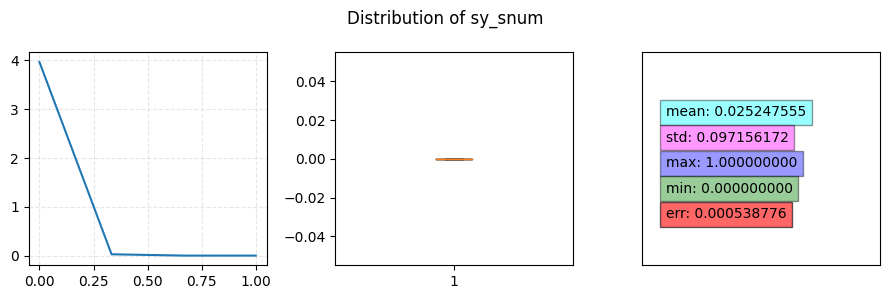

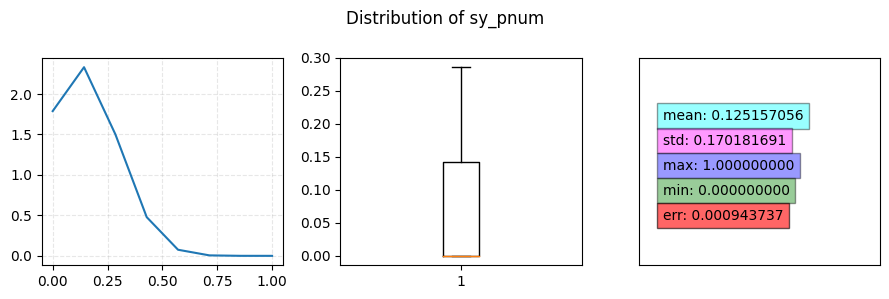

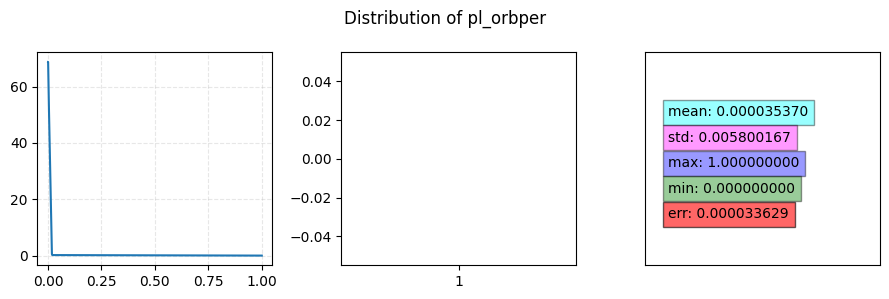

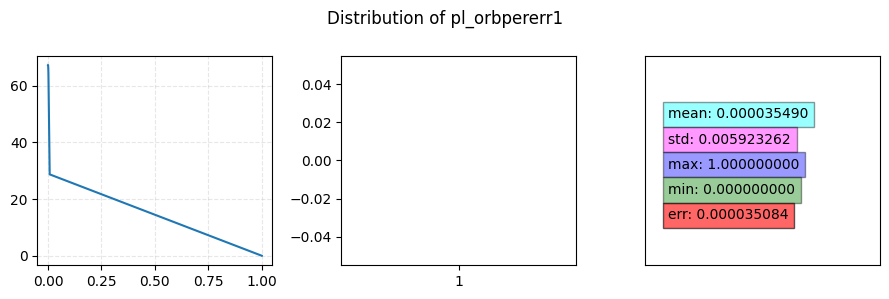

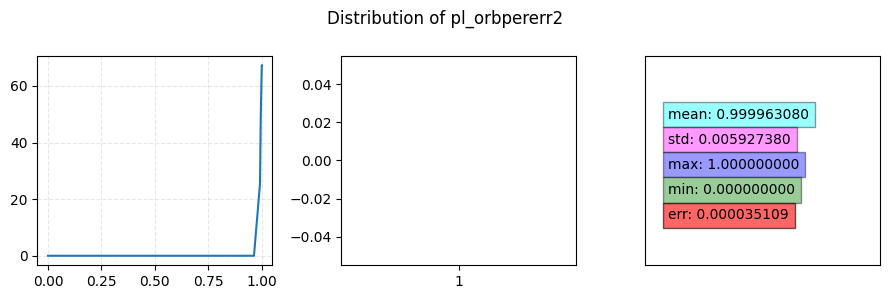

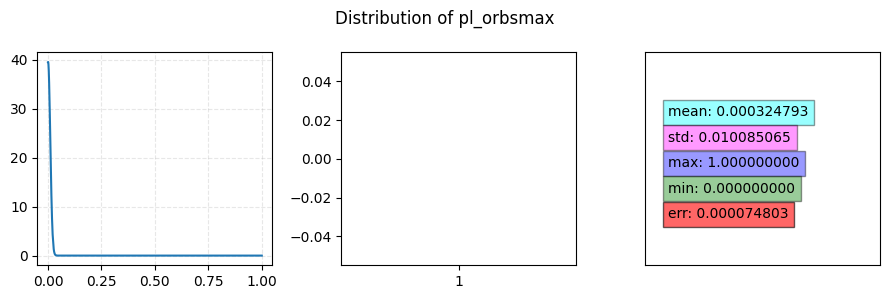

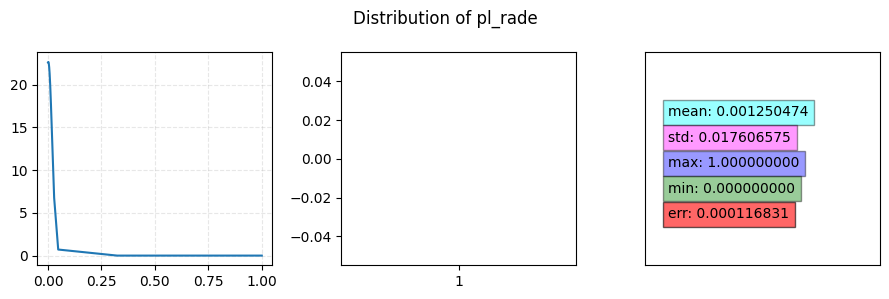

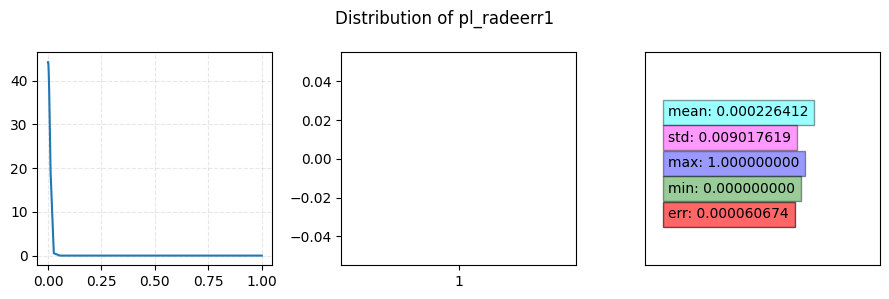

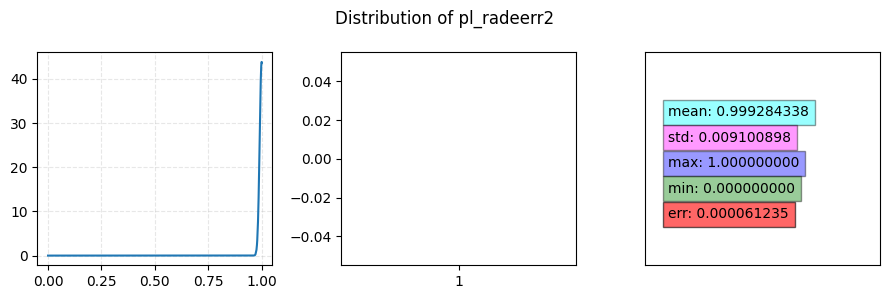

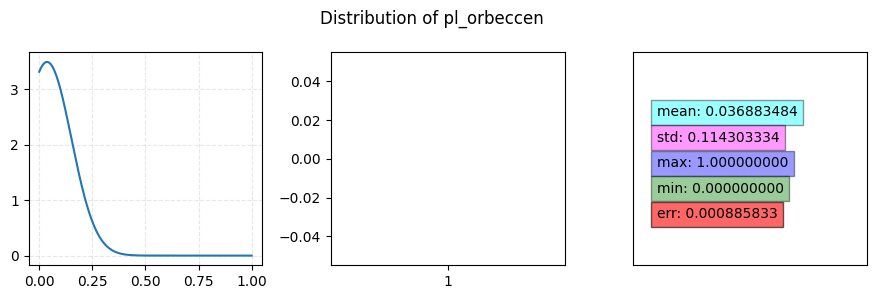

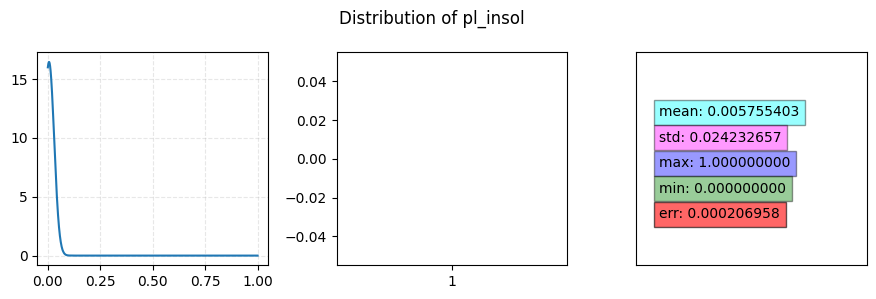

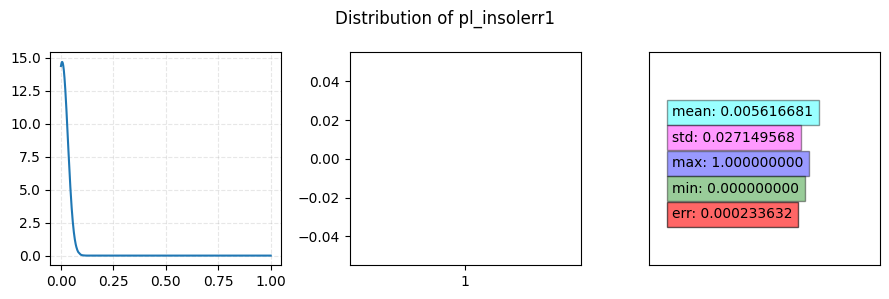

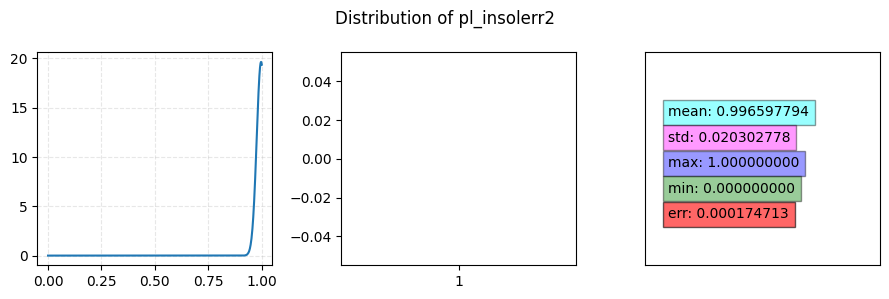

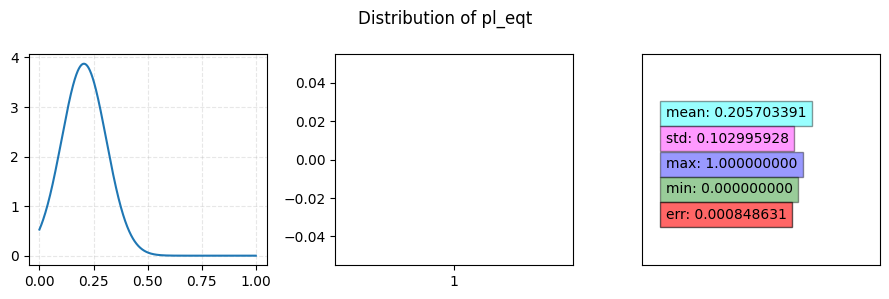

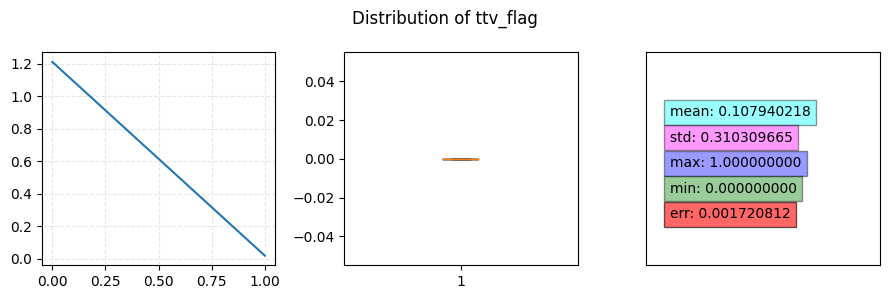

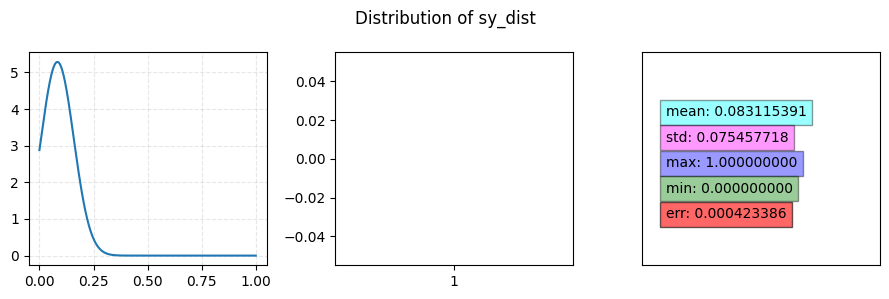

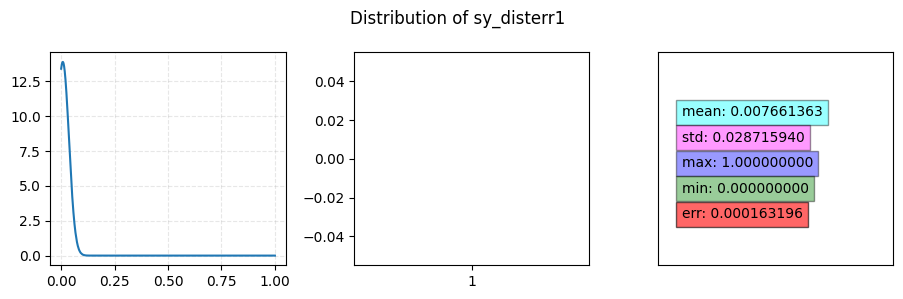

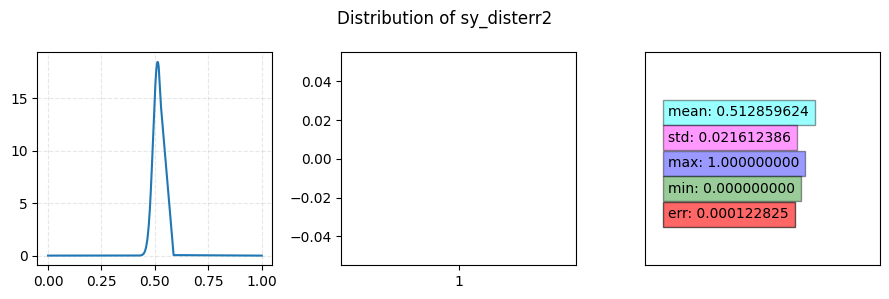

In [847]:
for col in df.columns:
    get_col_info(col)


The imputation, neighbors through 1 to 10 were tested beforehand and the closest mean and std were found with n = 3

In [848]:
imputer = KNNImputer(n_neighbors=3)
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

Checking the data after imputation

In [ ]:
df.head(10)

,sy_snum,sy_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbsmax,pl_rade,pl_radeerr1,pl_radeerr2,pl_orbeccen,pl_insol,pl_insolerr1,pl_insolerr2,pl_eqt,ttv_flag,sy_dist,sy_disterr1,sy_disterr2
0,0.333333,0.000000,8.107943e-07,6.808511e-10,1.000000,0.000171,0.000933,0.000034,0.999750,0.238144,0.001380,0.000033,0.999948,0.311338,0.0,0.010443,0.000517,0.517514
1,0.333333,0.000000,2.153158e-07,5.368085e-14,1.000000,0.000161,0.002860,0.000070,0.999423,0.356701,0.000089,0.000185,0.999943,0.098938,0.0,0.010443,0.000517,0.517514
2,0.000000,0.000000,6.098966e-06,1.371987e-06,0.999998,0.000201,0.001138,0.000180,0.998089,0.116838,0.026698,0.013956,0.985333,0.209827,0.0,0.014095,0.000531,0.517504
3,0.000000,0.000000,1.283904e-06,6.808511e-09,1.000000,0.000203,0.000830,0.000056,0.999394,0.082474,0.026698,0.013956,0.985333,0.069887,0.0,0.014095,0.000531,0.517504
4,0.000000,0.000000,1.283904e-06,6.914894e-09,1.000000,0.000205,0.000830,0.000056,0.999394,0.082474,0.026698,0.013956,0.985333,0.069887,0.0,0.014095,0.000531,0.517504
5,0.000000,0.000000,6.098966e-06,1.371987e-06,0.999998,0.000090,0.001154,0.000184,0.998151,0.089347,0.026692,0.013957,0.985332,0.209827,0.0,0.008426,0.000192,0.517730
6,0.000000,0.000000,4.620629e-07,4.893617e-10,1.000000,0.000110,0.001844,0.000080,0.999135,0.000000,0.026698,0.013956,0.985333,0.056690,0.0,0.008426,0.000192,0.517730
7,0.000000,0.142857,4.393829e-06,1.425532e-09,1.000000,0.000376,0.001037,0.000058,0.999399,0.378763,0.000290,0.000050,0.999915,0.218958,0.0,0.001890,0.000002,0.517856
8,0.000000,0.142857,4.288332e-06,1.063830e-07,1.000000,0.000375,0.001037,0.000058,0.999399,0.381443,0.000290,0.000050,0.999915,0.218958,0.0,0.001890,0.000002,0.517856
9,0.000000,0.142857,4.392809e-06,4.732766e-13,1.000000,0.000381,0.001037,0.000058,0.999399,0.370103,0.000290,0.000050,0.999915,0.218958,0.0,0.001890,0.000002,0.517856


Checking plots after imputation

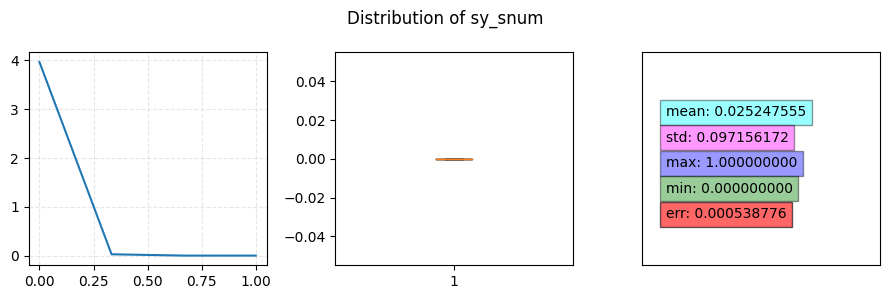

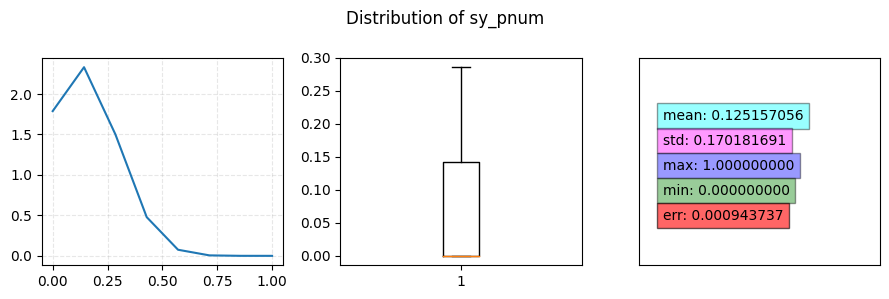

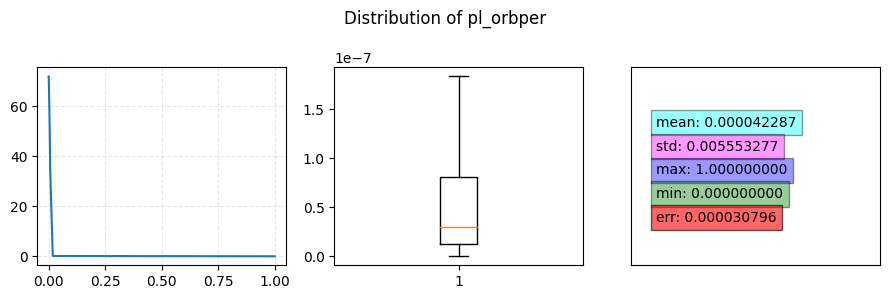

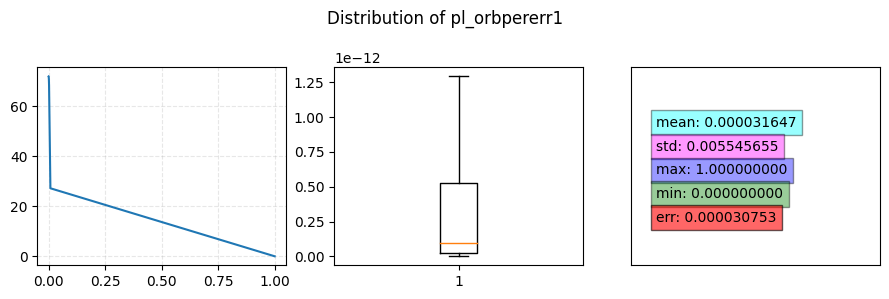

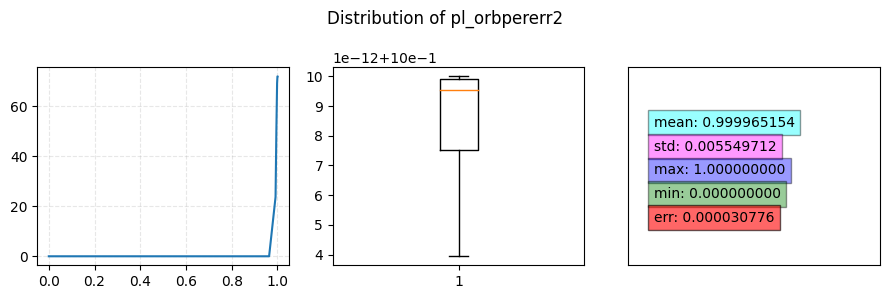

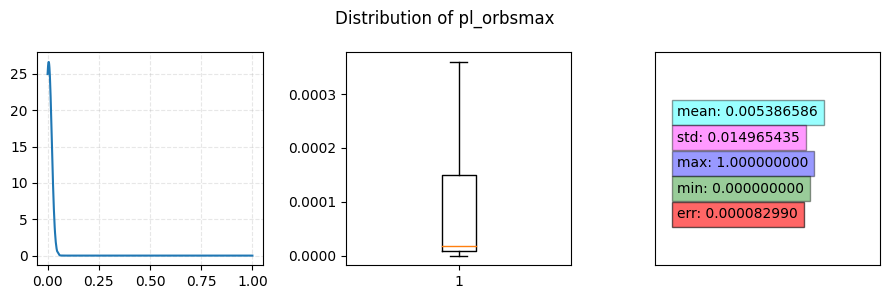

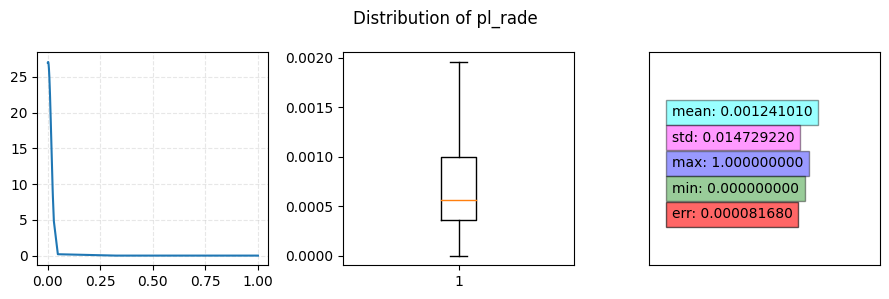

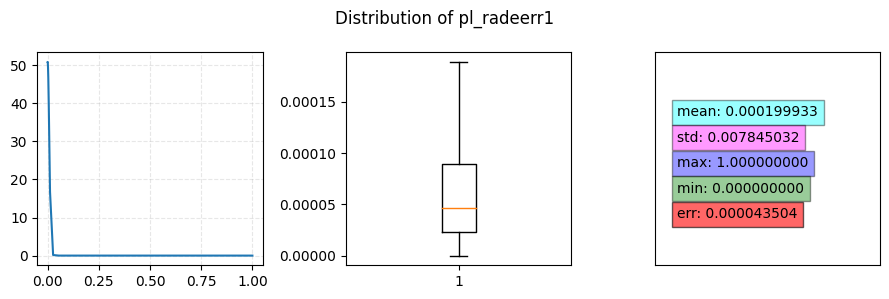

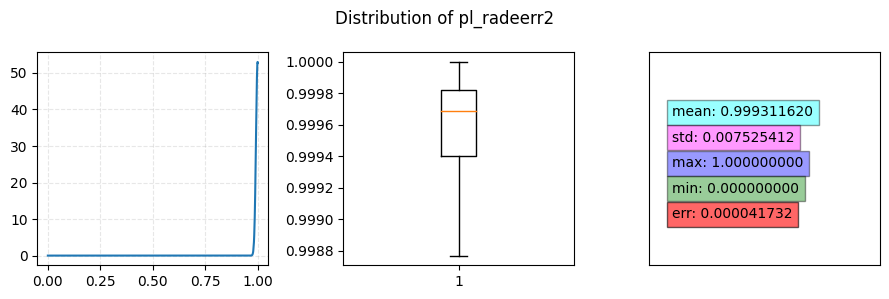

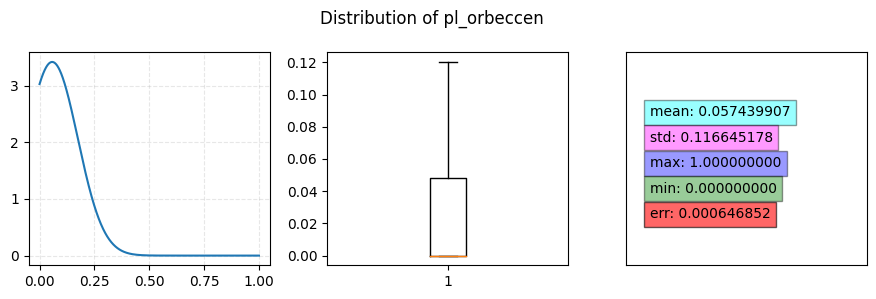

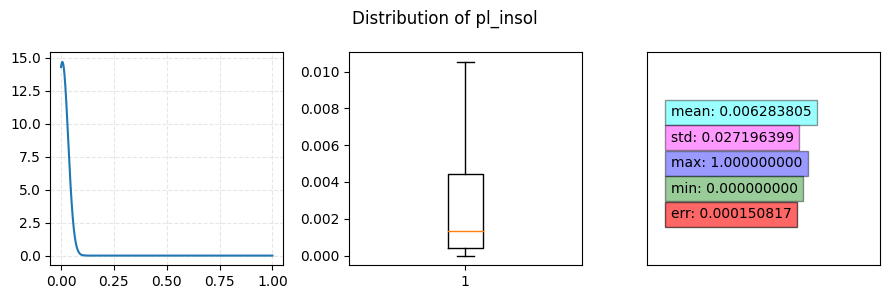

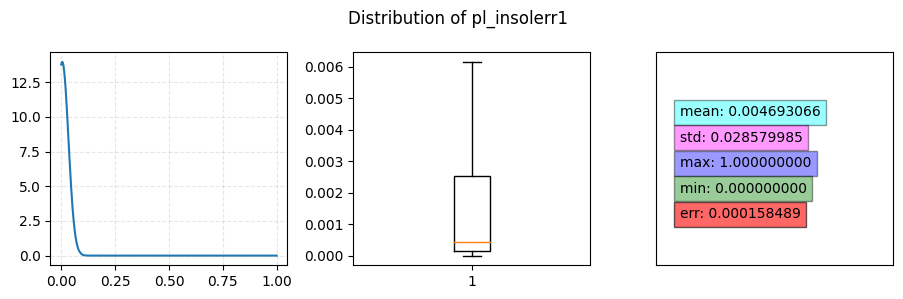

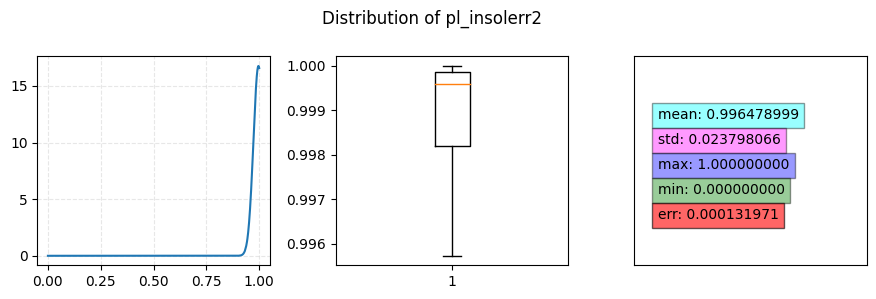

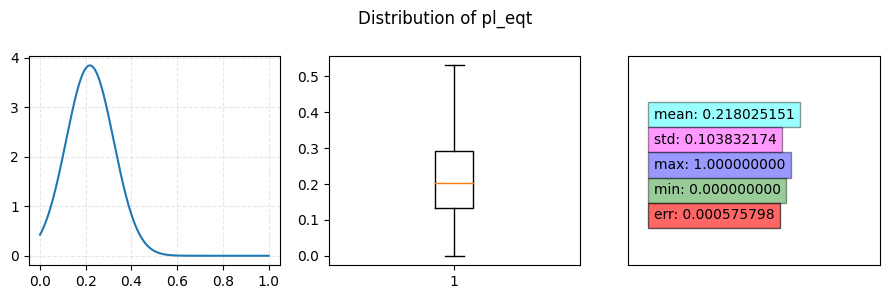

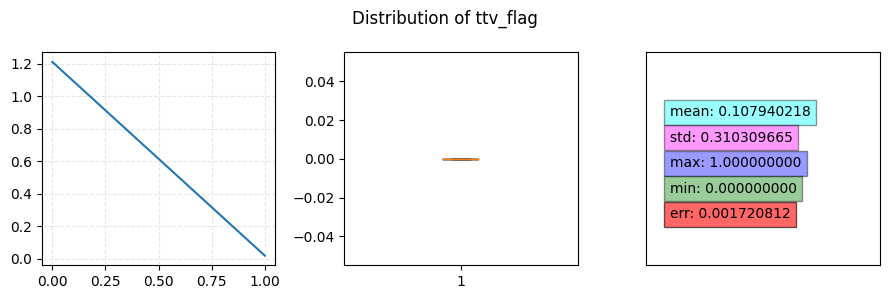

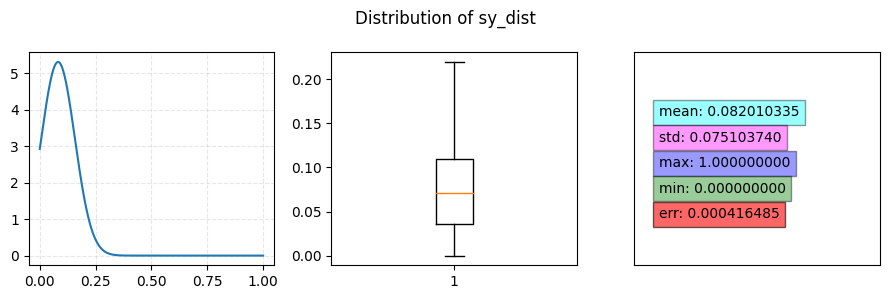

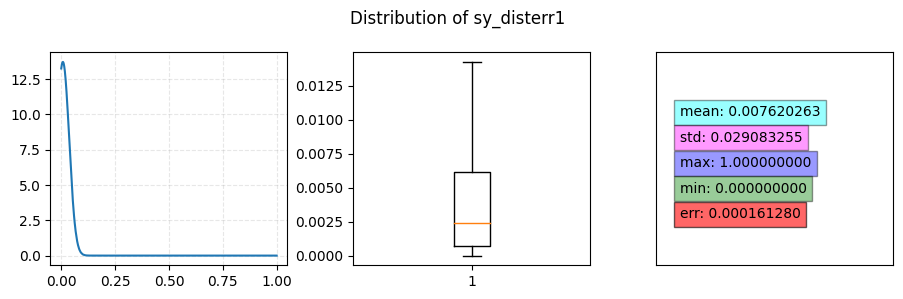

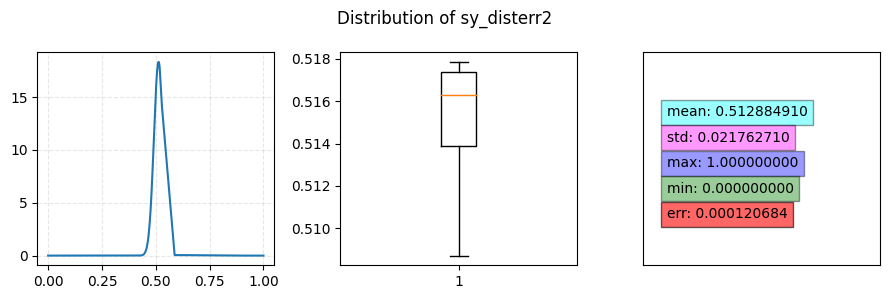

In [ ]:
for col in df.columns:
    get_col_info(col)

Checking null values

In [ ]:
df.isna().sum()


sy_snum          0
sy_pnum          0
pl_orbper        0
pl_orbpererr1    0
pl_orbpererr2    0
pl_orbsmax       0
pl_rade          0
pl_radeerr1      0
pl_radeerr2      0
pl_orbeccen      0
pl_insol         0
pl_insolerr1     0
pl_insolerr2     0
pl_eqt           0
ttv_flag         0
sy_dist          0
sy_disterr1      0
sy_disterr2      0
dtype: int64

<h1> Optimizing Clustering Method </h1>

Calculate inertias and distortions for elbow method

In [ ]:
distortions = []
inertias = []
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init='auto').fit(df)
    kmeanModel.fit(df)
  
    distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / df.shape[0])
    inertias.append(kmeanModel.inertia_)

Plotting the distortions

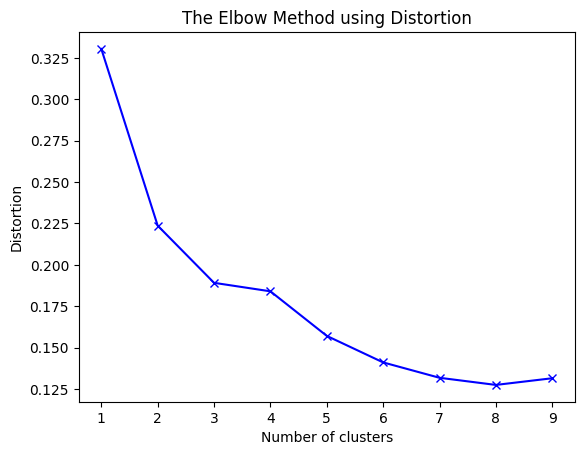

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Plotting Intertias

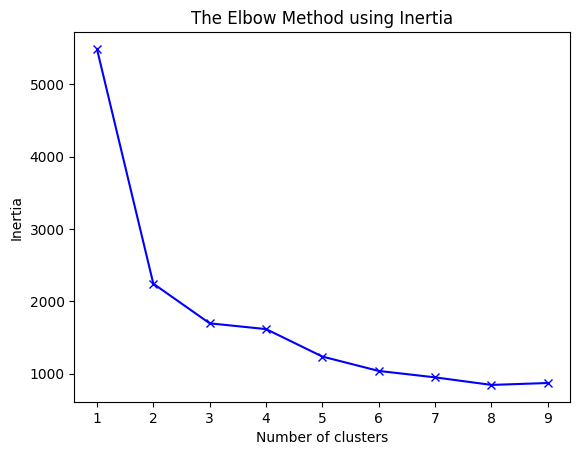

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()